In [22]:
# initialization
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile

# import basic plot tools
from qiskit.visualization import plot_histogram

# array as latex
from qiskit_textbook.tools import array_to_latex


## The Deutsch-Josza Problem

We are given a hidden boolean function $f$ :

$$ f(\{x_0,x_1,x_2,...\}) \rightarrow 0 \textrm{ or } 1 \textrm{ , where } x_i \textrm{ is } 0 \textrm{ or } 1 $$
  
and we know that it is either balanced (output is half zero half one) or constant (all zeros or ones)

### Classical Solution

In the worst case scenario we'd need to query the function $\tfrac{1}{2}2^n+1 = 2^{n-1}+1$ times to be sure whether it is balanced or constant. (Best case scenario is two for balanced)

### Quantum Solution

<img src="https://qiskit.org/textbook/ch-algorithms/images/deutsch_steps.png">

The above circuit solves the problem with only one call to the query.

#### Algorithm Description

1. Prepare two quantum registers:

    $$ |0\rangle^{\otimes n}|1\rangle $$
    
    
2. Apply Hadamard gate to each qubit:

    $$ \vert \psi_1 \rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle \left(|0\rangle - |1 \rangle \right) $$
    
3. Apply the quantum oracle $|x\rangle|y\rangle$ to $|x\rangle|y\otimes f(x)\rangle$

    $$ \begin{aligned}:
            \lvert \psi_2 \rangle  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1} \vert x\rangle (\vert f(x)\rangle - \vert 1 \oplus f(x)\rangle) \\  
                & = \frac{1}{\sqrt{2^{n+1}}}\sum_{x=0}^{2^n-1}(-1)^{f(x)}|x\rangle ( |0\rangle - |1\rangle ) 
        \end{aligned} $$
        
4. Now we can ignore second qubit register. Apply a Hadamard gate to each qubit in first register:

    $$ \begin{aligned}
            \lvert \psi_3 \rangle 
                & = \frac{1}{2^n}\sum_{x=0}^{2^n-1}(-1)^{f(x)}
                    \left[ \sum_{y=0}^{2^n-1}(-1)^{x \cdot y} 
                    \vert y \rangle \right] \\
                & = \frac{1}{2^n}\sum_{y=0}^{2^n-1}
                    \left[ \sum_{x=0}^{2^n-1}(-1)^{f(x)}(-1)^{x \cdot y} \right]
                    \vert y \rangle
        \end{aligned} $$
   where $x\cdot y = \sum\limits_{i=0}^{n-1}x\otimes y$
   
5. Measure the first register. Notice that the probability of measuring $|0\rangle^{\otimes n} = | \tfrac{1}{2^n}\sum\limits_{x=0}^{2^n-1}(-1)^{f(x)}|^2$ which evaluates to $1$ if $f(x)$ is constant and $0$ if $f(x)$ is balanced.

#### Run on Constant function

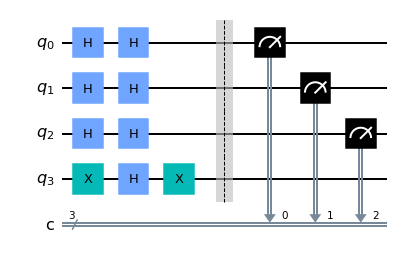

In [33]:
# Set up Quantum circuit with 4 qubits and 3 cbits for measurement
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
const_circuit = dj_circuit + const_oracle

# Repeat H-gates
for qubit in range(n):
    const_circuit.h(qubit)
const_circuit.barrier()

# Measure
for i in range(n):
    const_circuit.measure(i, i)

# Display circuit
const_circuit.draw(output='mpl')


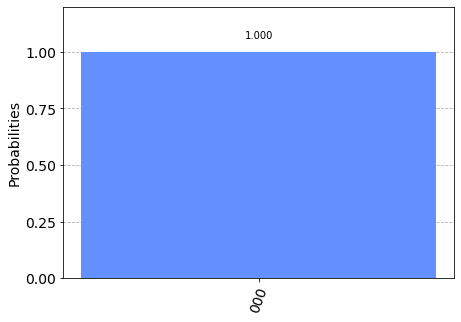

In [55]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(const_circuit, qasm_sim)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)


#### Try again with balanced oracle

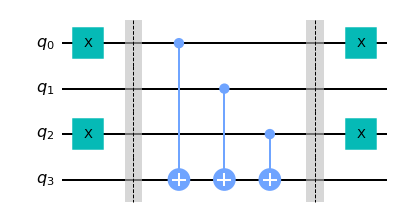

In [59]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw(output='mpl')

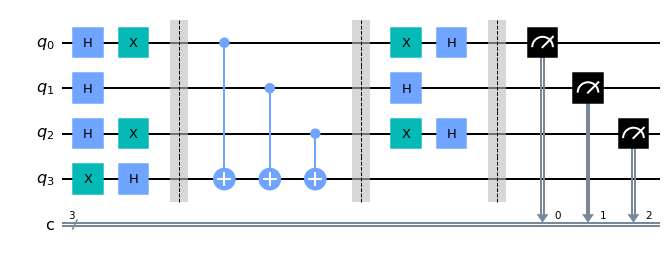

In [57]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
bal_circuit = dj_circuit + balanced_oracle

# Repeat H-gates
for qubit in range(n):
    bal_circuit.h(qubit)
bal_circuit.barrier()

# Measure
for i in range(n):
    bal_circuit.measure(i, i)

# Display circuit
bal_circuit.draw(output='mpl')

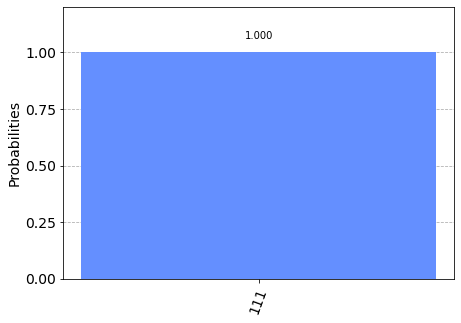

In [58]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(bal_circuit, qasm_sim)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)


So as we expect we get $|0\rangle^{\otimes n}$ if $f$ is constant and $|1\rangle^{\otimes n}$ if $f$ is balanced

### Setting up oracle as "black-box" gate

In [75]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [76]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

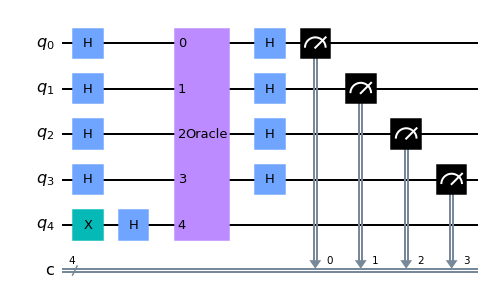

In [77]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw(output='mpl')

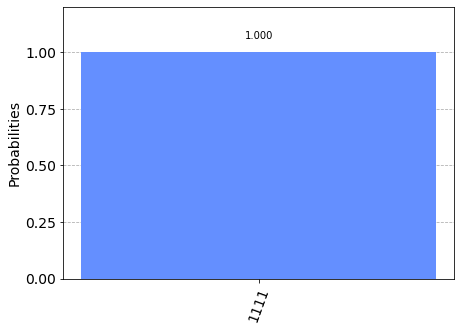

In [78]:
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

### Run on a real device

In [81]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

/opt/anaconda3/envs/Quantum_Computing/lib/python3.9/site-packages/qiskit/providers/ibmq/ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


least busy backend:  ibmq_quito


In [82]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
qobj = assemble(transpiled_dj_circuit, backend)
job = backend.run(qobj)
job_monitor(job, interval=2)


Job Status: job has successfully run


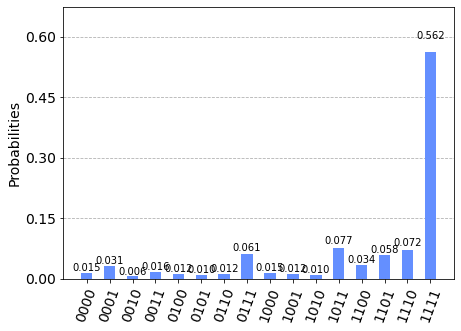

In [83]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)


We see that the majority are several 1's and the rest are due to quantum error.